# Predicting Shelter Animal Outcomes

In [185]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.cross_validation import KFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
import scipy.stats as stats


%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
import pydotplus
from sklearn.tree import export_graphviz

In [2]:
data = pd.read_csv("train.csv")
print(data.shape)
print(data.dtypes)

(26729, 10)
AnimalID          object
Name              object
DateTime          object
OutcomeType       object
OutcomeSubtype    object
AnimalType        object
SexuponOutcome    object
AgeuponOutcome    object
Breed             object
Color             object
dtype: object


In [3]:
data.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


In [4]:
data.isnull().sum()

AnimalID              0
Name               7691
DateTime              0
OutcomeType           0
OutcomeSubtype    13612
AnimalType            0
SexuponOutcome        1
AgeuponOutcome       18
Breed                 0
Color                 0
dtype: int64

In [5]:
data.OutcomeType.value_counts()

Adoption           10769
Transfer            9422
Return_to_owner     4786
Euthanasia          1555
Died                 197
Name: OutcomeType, dtype: int64

## 1. Formatting and Analyzing Individual Features
Before I start predicting outcomes, I need to format features to be suitable for analyses and see their individual relationship to the outcomes. 

### a. Animal Type

In [6]:
AnimalTypeGroup = data.groupby('AnimalType')
AnimalTypeGroup.OutcomeType.value_counts() 

AnimalType  OutcomeType    
Cat         Transfer           5505
            Adoption           4272
            Euthanasia          710
            Return_to_owner     500
            Died                147
Dog         Adoption           6497
            Return_to_owner    4286
            Transfer           3917
            Euthanasia          845
            Died                 50
Name: OutcomeType, dtype: int64

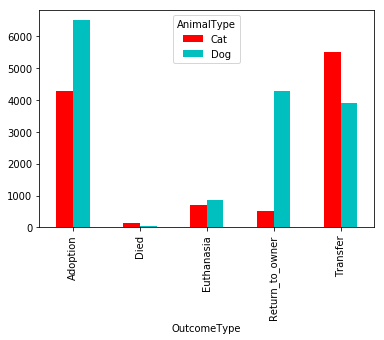

In [178]:
AnimalTypeGraph = data[['AnimalType','OutcomeType']].groupby(['OutcomeType','AnimalType']).size().unstack()
AnimalTypeGraph.plot(kind='bar',color=['r','c'])

### b. DateTime

In [7]:
#format Datetime
data['DateTime'] = pd.to_datetime(data['DateTime'])

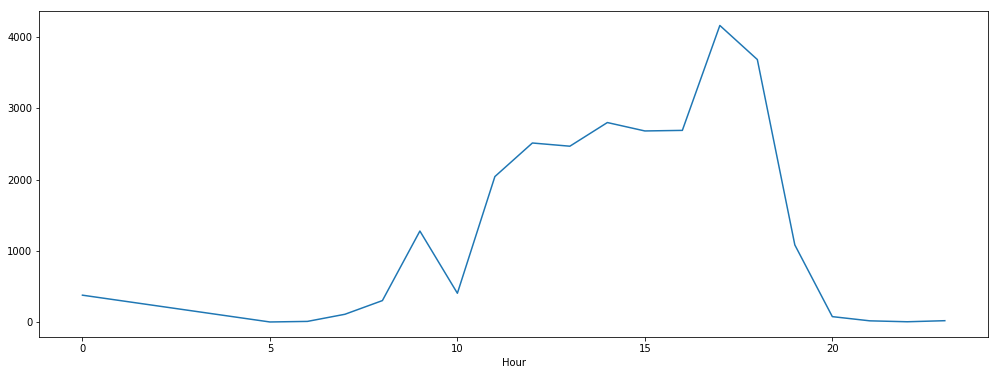

In [197]:
data['Hour'] = data.DateTime.dt.hour

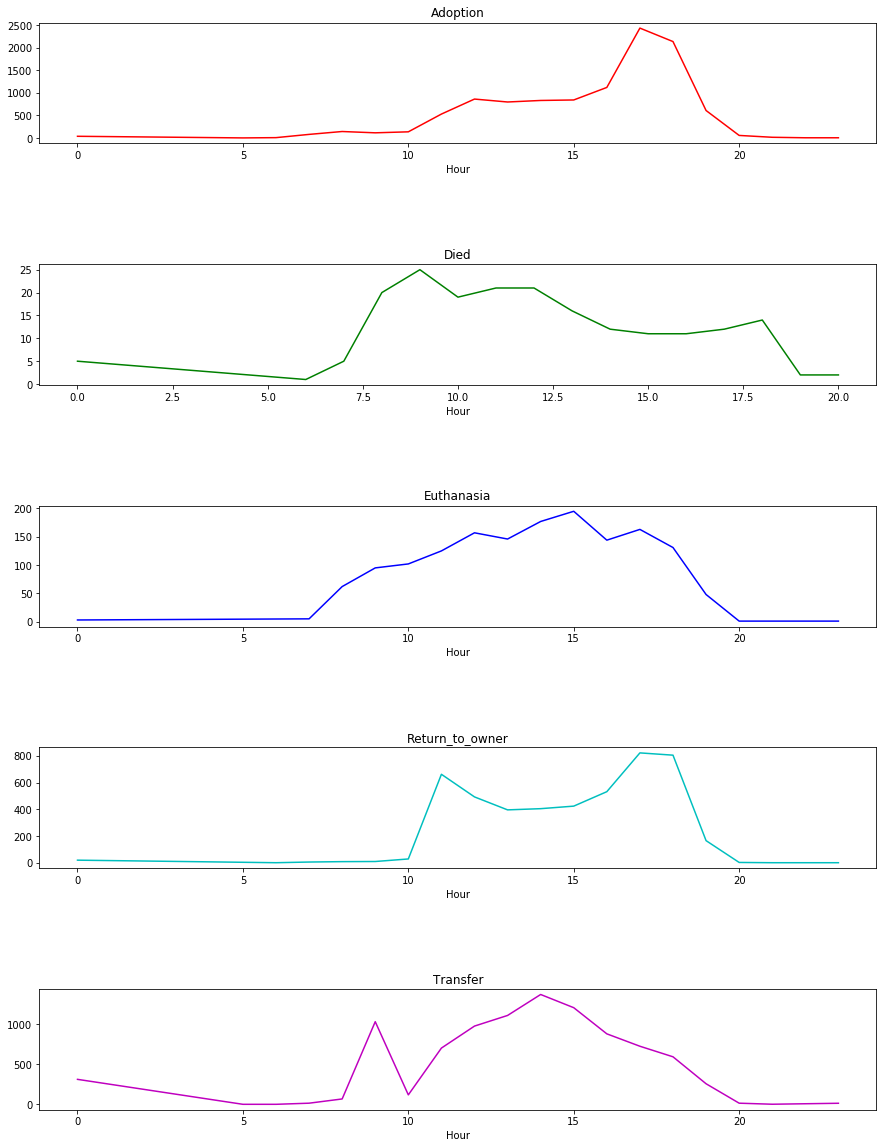

In [202]:
#For each outcome
hourGroup=data.Hour.groupby(data.OutcomeType)
plt.subplots(5, 1, figsize=(15, 20), sharex=True)
plt.subplots_adjust( hspace=1)
colors = list('rgbcmyk')
for i, (f, g) in enumerate(hourGroup):
    plt.subplot(5,1,i+1)
    plt.title(f)
    g.groupby(data.Hour).count().plot(kind="line", color=colors[i])

In [9]:
data['DoW'] = data.DateTime.dt.dayofweek

In [10]:
data['Month'] = data.DateTime.dt.month

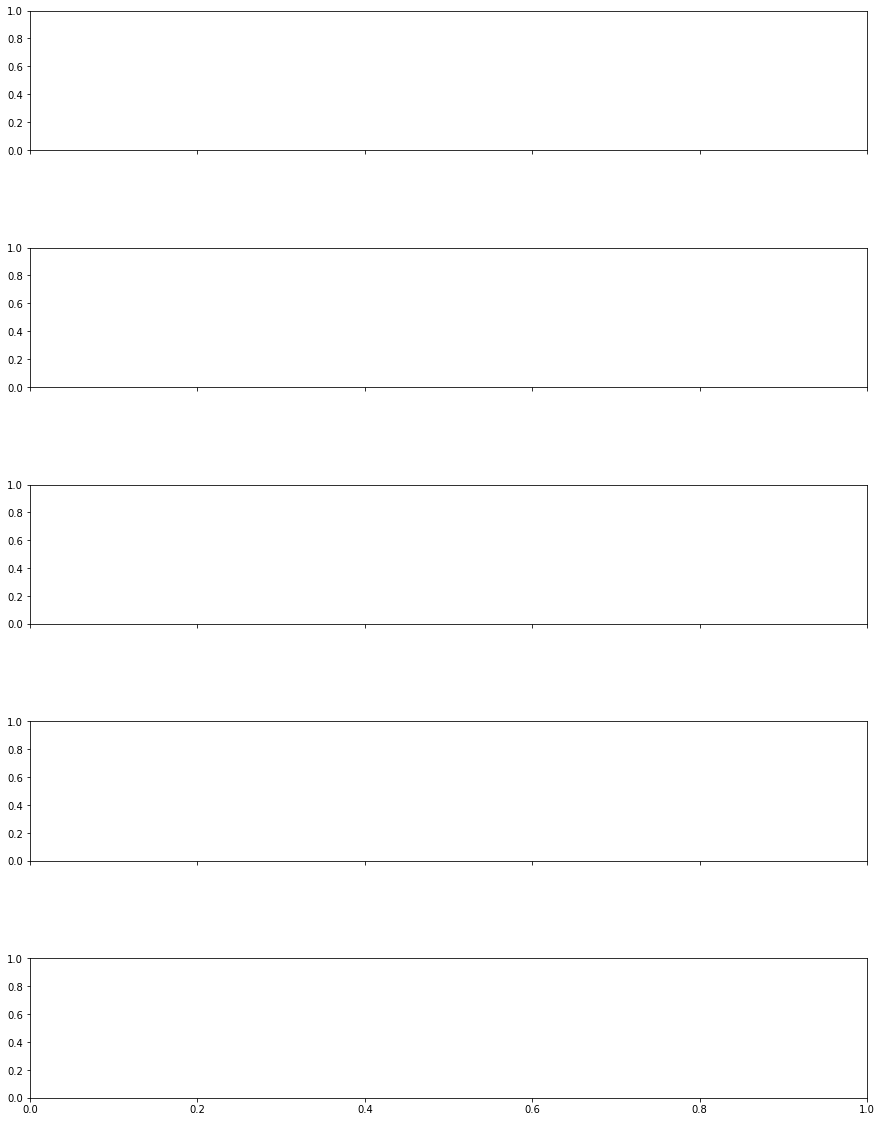

In [190]:
df_ym=data.DateTime.map(lambda x: x.strftime('%d'))
df_ym_outcomeGroup = df_ym.groupby(data["OutcomeType"])

plt.subplots(5, 1, figsize=(15, 20), sharex=True)
plt.subplots_adjust( hspace=0.7)
# colors = list('rgbcmyk')
# for i, (_, g) in enumerate(df_ym_outcomeGroup):
#     plt.subplot(5,1,i+1)
#     plt.title(_)
#     g.groupby(df_ym).count().plot(kind="line", color=colors[i])

In [11]:
data.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Hour,DoW,Month
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White,18,2,2
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby,12,6,10
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White,12,5,1
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream,19,4,7
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan,12,4,11


### c. Age

In [12]:
# create list of age in days
dataAge = data.AgeuponOutcome.tolist()
AgeinDays = []
for i in dataAge:
    try:
        num = (i.split()[0])
        letter = (i.split()[1][0])
        if(letter == 'y'):
            days = int(num)*365
        elif(letter == 'm'):
            days = int(num)*30
        elif(letter == 'w'):
            days = int(num)*7
        else:
            days = int(num)
        AgeinDays.append(days)
    except:
        AgeinDays.append(np.nan)

In [13]:
# check list
AgeinDays

[365,
 365,
 730,
 21,
 730,
 30,
 21,
 21,
 150,
 365,
 730,
 730,
 1460,
 730,
 365,
 90,
 21,
 14,
 730,
 365,
 60,
 365,
 730,
 300,
 60,
 30,
 180,
 1825,
 60,
 2555,
 1095,
 120,
 60,
 1825,
 1095,
 1095,
 1095,
 60,
 120,
 21,
 2555,
 60,
 60,
 1460,
 730,
 4380,
 3285,
 21,
 150,
 2190,
 365,
 90,
 21,
 730,
 60,
 7,
 60,
 365,
 1460,
 730,
 365,
 4015,
 30,
 730,
 14,
 2190,
 180,
 60,
 60,
 365,
 60,
 730,
 1095,
 365,
 1460,
 730,
 90,
 365,
 60,
 730,
 365,
 14,
 28,
 730,
 4380,
 365,
 60,
 14,
 90,
 90,
 150,
 1095,
 2555,
 730,
 120,
 3285,
 210,
 60,
 1095,
 1095,
 1825,
 1825,
 14,
 14,
 1460,
 1460,
 60,
 730,
 730,
 3285,
 1825,
 365,
 730,
 21,
 150,
 2190,
 365,
 90,
 30,
 1095,
 1825,
 2920,
 60,
 2555,
 60,
 1825,
 365,
 90,
 730,
 3285,
 1095,
 1095,
 365,
 730,
 365,
 730,
 730,
 730,
 90,
 30,
 60,
 300,
 730,
 60,
 180,
 60,
 365,
 180,
 365,
 21,
 730,
 330,
 90,
 730,
 730,
 730,
 120,
 120,
 150,
 60,
 2555,
 1460,
 21,
 180,
 150,
 2920,
 60,
 30,
 150,
 

In [14]:
# append numerical age column to data set
data['AgeinDays'] = AgeinDays

In [15]:
print(data.AgeinDays.isnull().sum())
data.AgeinDays.nunique()

18


43

In [16]:
age_median =  data.AgeinDays.median()
age_median

365.0

In [17]:
data.AgeinDays.fillna(age_median, inplace=True)
print(data.AgeinDays.isnull().sum())

0


In [18]:
# Break age into baby(0-6 months), puppy(6-18 months), adult (18 - inf)
data['Lifestage'] = pd.cut(data.AgeinDays,[-1,180,365,np.inf])
data.Lifestage.value_counts()

(365.0, inf]      10852
(-1.0, 180.0]     10353
(180.0, 365.0]     5524
Name: Lifestage, dtype: int64

In [19]:
del data['AgeuponOutcome']
data.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,Breed,Color,Hour,DoW,Month,AgeinDays,Lifestage
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,Shetland Sheepdog Mix,Brown/White,18,2,2,365.0,"(180.0, 365.0]"
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,Domestic Shorthair Mix,Cream Tabby,12,6,10,365.0,"(180.0, 365.0]"
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,Pit Bull Mix,Blue/White,12,5,1,730.0,"(365.0, inf]"
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,Domestic Shorthair Mix,Blue Cream,19,4,7,21.0,"(-1.0, 180.0]"
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,Lhasa Apso/Miniature Poodle,Tan,12,4,11,730.0,"(365.0, inf]"


### d. Breed Data

In [20]:
# create column to identify mixed breeds
mixMask = ['Mix' in breed for breed in data.Breed.tolist()]
mixMask[:10]

[True, True, True, True, False, False, True, True, True, False]

In [22]:
data['MixedBreed'] = mixMask
data.MixedBreed = data.MixedBreed.astype(int)


In [23]:
# Simplify breed data
data[['FirstBreed','SecondBreed','ThirdBreed']] = data.Breed.str.split("/", expand=True)


In [24]:
BreedData = data.FirstBreed.tolist()
FirstBreedList = []
for breed in BreedData:
    if "Mix" in breed: 
        breed = breed[0:-4]
    FirstBreedList.append(breed)

In [25]:
data['FirstBreed'] = FirstBreedList

In [26]:
# 80% of data is within first 20 breeds
(data.FirstBreed.value_counts()/data.FirstBreed.shape[0]).cumsum()[19]

0.8001795802312095

In [27]:
# keep first 20 breeds and categorize the rest as other
top20breeds = []
top20value = data.FirstBreed.value_counts()[19]
for breed in FirstBreedList:
    if FirstBreedList.count(breed) < top20value:
        breed = 'Other'
    top20breeds.append(breed)
    


In [28]:
data['Top20Breeds'] = top20breeds

In [29]:
data.Top20Breeds.value_counts()

Domestic Shorthair       8958
Other                    5341
Chihuahua Shorthair      2145
Pit Bull                 2113
Labrador Retriever       1915
Domestic Medium Hair      883
German Shepherd           826
Domestic Longhair         547
Australian Cattle Dog     511
Dachshund                 510
Siamese                   426
Boxer                     360
Border Collie             334
Miniature Poodle          310
Australian Shepherd       229
Yorkshire Terrier         226
Jack Russell Terrier      222
Miniature Schnauzer       220
Beagle                    220
Catahoula                 218
Rat Terrier               215
Name: Top20Breeds, dtype: int64

### e. Color

In [30]:
data[['FirstColor','SecondColor']] = data.Color.str.split("/", expand=True)
print(data.FirstColor.nunique())
data.FirstColor.value_counts().sum()

57


26729

In [32]:
# 93% of data in top 20 colors 
(data.FirstColor.value_counts()/data.FirstColor.shape[0]).cumsum()[19]

0.9255864416925439

In [33]:
firstColorList = data.FirstColor.tolist()
top20colors = []
top20color = data.FirstColor.value_counts()[19]
for color in firstColorList:
    if firstColorList.count(color) < top20color:
        color = 'Other'
    top20colors.append(color)
    

In [34]:
data['Top20Colors'] = top20colors

In [35]:
data.Top20Colors.value_counts()

Black            6422
White            3344
Brown Tabby      2592
Other            1989
Brown            1951
Tan              1674
Orange Tabby     1299
Blue             1199
Tricolor          800
Red               779
Brown Brindle     699
Blue Tabby        678
Tortie            580
Calico            552
Chocolate         448
Torbie            398
Sable             324
Cream Tabby       277
Buff              267
Yellow            230
Gray              227
Name: Top20Colors, dtype: int64

### f. Sex and Sterilization

Sex and Sterilization are two distinct features so it makes more sense to separate it into two columns instead of individual dummy columns. 

In [40]:
data.SexuponOutcome.value_counts()

Neutered Male    9779
Spayed Female    8820
Intact Male      3525
Intact Female    3511
Unknown          1093
9779                1
Name: SexuponOutcome, dtype: int64

In [41]:
data.SexuponOutcome.replace(to_replace= 9779, value= "Unknown", inplace=True)

In [42]:
# Fill missing value
most_frequent = data.SexuponOutcome.value_counts()[0]
data.SexuponOutcome.fillna(most_frequent, inplace=True)
data.SexuponOutcome.value_counts()

Neutered Male    9779
Spayed Female    8820
Intact Male      3525
Intact Female    3511
Unknown          1094
Name: SexuponOutcome, dtype: int64

In [43]:
# Separate SexuponOutcome column into Sex and Neutered/Spayed 
# Female = 1 and Intact = 1
sexMask = ['Female' in sex for sex in data.SexuponOutcome.tolist()]
sterileMask = ['Intact' in fix for fix in data.SexuponOutcome.tolist()]

In [44]:
data['Sex'] = sexMask
data['Sterile'] = sterileMask
data.Sex = data.Sex.astype(int)
data.Sterile = data.Sterile.astype(int)

In [45]:
data.Sex.value_counts() 

0    14398
1    12331
Name: Sex, dtype: int64

In [46]:
data.Sterile.value_counts()

0    19693
1     7036
Name: Sterile, dtype: int64

In [47]:
del data['SexuponOutcome']
data.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,Breed,Color,Hour,DoW,...,MixedBreed,FirstBreed,SecondBreed,ThirdBreed,Top20Breeds,FirstColor,SecondColor,Top20Colors,Sex,Sterile
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Shetland Sheepdog Mix,Brown/White,18,2,...,1,Shetland Sheepdog,None,None,Other,Brown,White,Brown,0,0
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Domestic Shorthair Mix,Cream Tabby,12,6,...,1,Domestic Shorthair,None,None,Domestic Shorthair,Cream Tabby,None,Cream Tabby,1,0
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Pit Bull Mix,Blue/White,12,5,...,1,Pit Bull,None,None,Pit Bull,Blue,White,Blue,0,0
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Domestic Shorthair Mix,Blue Cream,19,4,...,1,Domestic Shorthair,None,None,Domestic Shorthair,Blue Cream,None,Other,0,1
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Lhasa Apso/Miniature Poodle,Tan,12,4,...,0,Lhasa Apso,Miniature Poodle,None,Other,Tan,None,Tan,0,0


## Logistic Regression

In [50]:
data.columns.tolist()

['AnimalID',
 'Name',
 'DateTime',
 'OutcomeType',
 'OutcomeSubtype',
 'AnimalType',
 'Breed',
 'Color',
 'Hour',
 'DoW',
 'Month',
 'AgeinDays',
 'Lifestage',
 'MixedBreed',
 'FirstBreed',
 'SecondBreed',
 'ThirdBreed',
 'Top20Breeds',
 'FirstColor',
 'SecondColor',
 'Top20Colors',
 'Sex',
 'Sterile']

In [131]:
# Generate features and target
feature_cols = ['AnimalType',
 'Hour',
 'DoW',
 'Month',
 'AgeinDays',
 'Lifestage',
 'MixedBreed',
 'FirstBreed',
 'FirstColor',
 'Sex',
 'Sterile'
 ]
le = LabelEncoder()
encoded_X = data[feature_cols].apply(le.fit_transform)
X = encoded_X
y = le.fit_transform(data.OutcomeType)

In [151]:
# Compute Logistic Regression to Predict Outcome
logreg = LogisticRegression()
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.3)
logreg.fit(X_train,y_train)
OutcomePredLog = logreg.predict(X_test)
print('Model Accuracy:',metrics.accuracy_score(y_test, OutcomePredLog))

Model Accuracy: 0.6091782017707944


In [152]:
cross_val_scores_log = cross_val_score(logreg,X,y,cv=10,scoring='accuracy')
print("Mean cross validation accuracy:",np.mean(cross_val_scores_log))
print("Std of cross validation accuracy:",np.std(cross_val_scores_log))

Mean cross validation accuracy: 0.6167836371232884
Std of cross validation accuracy: 0.005204415389481044


In [144]:
list(zip(feature_cols, logreg.coef_[0]))

[('AnimalType', 0.10034897634548264),
 ('Hour', 0.1417539527555945),
 ('DoW', 0.12803734586097285),
 ('Month', 0.004093450676008533),
 ('AgeinDays', 0.033569055117932615),
 ('Lifestage', -1.0250236731522988),
 ('MixedBreed', -0.13298809555767413),
 ('FirstBreed', -0.0007992556396516648),
 ('FirstColor', 0.00018392583513027595),
 ('Sex', 0.4610498781197694),
 ('Sterile', -3.3857188678475767)]

In [135]:
# Generate Random Forest with 500 trees using train_test_split method
rf100 = RandomForestClassifier(n_estimators=100)

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.3)
rf100.fit(X_train, y_train)
y_pred_rf_100 = rf100.predict(X_test)

print("Random Forest Train-Test accuracy:",metrics.accuracy_score(y_test,y_pred_rf_100))

Random Forest Train-Test accuracy: 0.6569397680508792


In [136]:
# random forest with cross validation method
cross_val_scores_100 = cross_val_score(rf100,X,y,cv=10,scoring='accuracy')
print("Mean cv-accuracy:",np.mean(cross_val_scores_100))
print("Std of cv-accuracy:",np.std(cross_val_scores_100))

Mean cv-accuracy: 0.6547187244769931
Std of cv-accuracy: 0.006864103597616911


In [138]:
pd.DataFrame({'feature':feature_cols, 
              'importance':rf100.feature_importances_}).sort_values(by='importance', ascending=False)

,feature,importance
4,AgeinDays,0.173443
1,Hour,0.151671
3,Month,0.128473
7,FirstBreed,0.122730
8,FirstColor,0.111659
10,Sterile,0.111158
2,DoW,0.095375
5,Lifestage,0.036085
9,Sex,0.027774
0,AnimalType,0.022519


### Grid Search on Logistic Regression and Random Forest

In [61]:
from sklearn.model_selection import GridSearchCV

In [ ]:
rf_for_grid = RandomForestClassifier(random_state=1, n_jobs=-1)
estimator_range = range(10,101,10)
feature_range = range(1,len(feature_cols)+1)
param_grid = dict(n_estimators = estimator_range, 
                  max_features = feature_range)
RFgrid = GridSearchCV(rf_for_grid, param_grid, cv=10, scoring='accuracy')
RFgrid.fit(X, y)


In [65]:
rf_for_grid.get_params()

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

In [105]:
RFgrid.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=-1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [107]:
RFgrid.best_score_

0.6543454674697894

In [108]:
RFgrid.best_params_

{'max_features': 5, 'n_estimators': 70}

In [109]:
RFgrid.grid_scores_

/Users/Nicole/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.62711, std: 0.00663, params: {'max_features': 1, 'n_estimators': 10},
 mean: 0.63908, std: 0.00675, params: {'max_features': 1, 'n_estimators': 20},
 mean: 0.64286, std: 0.00555, params: {'max_features': 1, 'n_estimators': 30},
 mean: 0.64499, std: 0.00599, params: {'max_features': 1, 'n_estimators': 40},
 mean: 0.64481, std: 0.00592, params: {'max_features': 1, 'n_estimators': 50},
 mean: 0.64623, std: 0.00525, params: {'max_features': 1, 'n_estimators': 60},
 mean: 0.64757, std: 0.00513, params: {'max_features': 1, 'n_estimators': 70},
 mean: 0.64828, std: 0.00484, params: {'max_features': 1, 'n_estimators': 80},
 mean: 0.64772, std: 0.00579, params: {'max_features': 1, 'n_estimators': 90},
 mean: 0.64813, std: 0.00535, params: {'max_features': 1, 'n_estimators': 100},
 mean: 0.63167, std: 0.00681, params: {'max_features': 2, 'n_estimators': 10},
 mean: 0.64073, std: 0.00632, params: {'max_features': 2, 'n_estimators': 20},
 mean: 0.64365, std: 0.00563, params: {'max_feature

In [162]:
rf_best = RandomForestClassifier(n_estimators=70, max_features=5, max_depth = 12)
rf_best.fit(X,y)
print("Mean Accuracy for depth 12:", cross_val_score(rf_best, X, y, scoring='accuracy').mean())

Mean Accuracy for depth 12: 0.6638116067849569


In [163]:
# compute feature importances
pd.DataFrame({'feature':feature_cols, 
              'importance':rf_best.feature_importances_}).sort_values(by='importance', ascending=False)

,feature,importance
4,AgeinDays,0.241419
10,Sterile,0.227799
1,Hour,0.151189
7,FirstBreed,0.070196
2,DoW,0.066118
3,Month,0.061046
5,Lifestage,0.059693
8,FirstColor,0.052125
0,AnimalType,0.042424
9,Sex,0.019000


In [67]:
log_for_grid = LogisticRegression()
param_grid2 = {"penalty":['l1','l2'], 'C':[0.1,1,10,100]}
LogGrid = GridSearchCV(log_for_grid, param_grid2, cv=10, scoring='accuracy')
LogGrid.fit(X, y)

GridSearchCV(cv=10, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [66]:
log_for_grid.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'max_iter': 100,
 'multi_class': 'ovr',
 'n_jobs': 1,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [69]:
LogGrid.grid_scores_

/Users/Nicole/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.61716, std: 0.00464, params: {'C': 0.1, 'penalty': 'l1'},
 mean: 0.61551, std: 0.00546, params: {'C': 0.1, 'penalty': 'l2'},
 mean: 0.61705, std: 0.00520, params: {'C': 1, 'penalty': 'l1'},
 mean: 0.61693, std: 0.00524, params: {'C': 1, 'penalty': 'l2'},
 mean: 0.61686, std: 0.00516, params: {'C': 10, 'penalty': 'l1'},
 mean: 0.61708, std: 0.00527, params: {'C': 10, 'penalty': 'l2'},
 mean: 0.61682, std: 0.00533, params: {'C': 100, 'penalty': 'l1'},
 mean: 0.61708, std: 0.00516, params: {'C': 100, 'penalty': 'l2'}]

In [70]:
LogGrid.best_score_

0.6171573945901455

In [71]:
LogGrid.best_params_

{'C': 0.1, 'penalty': 'l1'}

In [154]:
# beta values of best Logistic Regression Model
best_log = LogisticRegression(C=0.1, penalty='l1')
betas = best_log.fit(X,y).coef_[0]
best_betas = pd.DataFrame(list(zip(feature_cols,np.abs(betas))),columns=["features","betas"])
best_betas.sort_values("betas",ascending=False,inplace=True)
best_betas

,features,betas
10,Sterile,3.425089
5,Lifestage,0.963674
9,Sex,0.472816
1,Hour,0.139518
2,DoW,0.126128
6,MixedBreed,0.124157
0,AnimalType,0.099536
4,AgeinDays,0.026314
3,Month,0.006452
7,FirstBreed,0.000966


In [46]:
from sklearn.dummy import DummyClassifier
dumb_model = DummyClassifier(strategy='most_frequent')
dumb_model.fit(X_train, y_train)
y_dumb_class = dumb_model.predict(X_test)
print("Most frequent class dummy classifier test accuracy: ",metrics.accuracy_score(y_test, y_dumb_class))


Most frequent class dummy classifier test accuracy:  0.4055368499812944


In [103]:
for i in range(10,101,10):
    print(i)

10
20
30
40
50
60
70
80
90
100
